# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

# Overview of the project
This project aims to work on a data set coming from a fictive company offering music listening service. This company is called Sparkify. Users of that service can listen music from their devices and are offered to either a free service or a paid service. The data set we will use is a server log file containing details of each user session.
Sparkify would like to understand who are the user who leave the service and recognize them based on their behaviour. For that purpose we will do the following:
1. clean the data that are provided to us (server log file)
2. explore those data to familiarize with what info are available to us and how churned user are represented in the overall user population
3. build few machine learning algo that we will train to recognize who are the user who churn.

In a final step we will conclude on this exercice, with a summary of our findings.

## let's start with the spark initialization + couple of imports

In [415]:
! python --version

Python 3.6.3


In [416]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType, FloatType
from pyspark.sql import Window

from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
#from pyspark.sql.functions import sum as Fsum
from pyspark.sql import functions as F

import datetime
import re
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [417]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

In [418]:
spark.sparkContext.getConf().getAll()

[('spark.master', 'local'),
 ('spark.driver.host', '09f668244dcb'),
 ('spark.app.id', 'local-1572709878775'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '37875'),
 ('spark.ui.showConsoleProgress', 'true')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [419]:
# load data from the json file
sparkify_data_file = "./mini_sparkify_event_data.json"
event_data = spark.read.json(sparkify_data_file)
#event_data.persist()

## Let's perform some basic exploration of the data set

In [420]:
event_data.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [421]:
event_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [422]:
# number of events in the log file
event_data.count()

286500

### Check user Id and session Id.
It is sugguested to look at them since it might be required to do some cleaning here

In [423]:
event_data.select("userId").dropDuplicates().sort("userId").show(3)

+------+
|userId|
+------+
|      |
|    10|
|   100|
+------+
only showing top 3 rows



In [424]:
event_data.filter(event_data["userId"] == "").count()

8346

In [425]:
event_data.filter(event_data["sessionId"] == "").count()

0

In [426]:
# As suggested, let's remove any row with missing data in the userId and sessionId columns
user_log_valid = event_data.dropna(how = "any", subset = ["userId", "sessionId"])

In [427]:
user_log_valid.count()

286500

We see that we have not dropped any data. Indeed there were no missing sessionId, and the missing userId is not really a "na" data. This is an empty string !!!
To remove this empty string I propose to "filter" for them.
ATTENTION: I'm working with the small dataset here. It might be the case that in the large dataset, there will be some NA for those columns.

In [428]:
user_log_valid.filter(user_log_valid["userId"] == "").count()

8346

In [429]:
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [430]:
user_log_valid.count()

278154

In [431]:
286500-278154

8346

In [432]:
# display function to help loop over columns
def display_column(col_name, nb_row=5):
    user_log_valid.select(col_name).distinct().show(nb_row)

In [433]:
for col in user_log_valid.schema.names: display_column(col)

+----------------+
|          artist|
+----------------+
|  The Black Keys|
|     Silverstein|
|       Kate Nash|
|    Yann Tiersen|
|Jane's Addiction|
+----------------+
only showing top 5 rows

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+

+---------+
|firstName|
+---------+
|   Maddox|
|   Karter|
|    Lucas|
|    Grace|
| Antonina|
+---------+
only showing top 5 rows

+------+
|gender|
+------+
|     F|
|     M|
+------+

+-------------+
|itemInSession|
+-------------+
|           26|
|           29|
|          474|
|          964|
|           65|
+-------------+
only showing top 5 rows

+--------+
|lastName|
+--------+
|Harrison|
|Thornton|
|    Pena|
|   Jones|
|  Santos|
+--------+
only showing top 5 rows

+---------+
|   length|
+---------+
|200.75057|
|317.30893|
|260.28363|
|241.94567|
|262.79138|
+---------+
only showing top 5 rows

+-----+
|level|
+-----+
| free|
| paid|
+-----+

+--------------------+
|            location|
+--------------------+

So far I understand the following:

Each line of the spark dataframe is a record which is related to a user requesting a page with a PUT or GET method.
User is repsented by userId and each session has an id as well. There is even a itemInSession column that provide the sequence of all pages the users visited within a session. ts column provide a timestamp of the "event" in those logs.
UserAgent tells us about the operating system and browser used. Status is the return code of the server. Level is telling us if the user is using the free version or if he is under paid contract.
Other field are pretty obvious and their name is pretty explanatory.
The only one I don't understand is about the lenght. Let's explore a little bit this one.

In [434]:
for page in user_log_valid.select("page").distinct().collect():
    print(user_log_valid.select("page","length").where(user_log_valid.page == page[0]).distinct().collect())

[Row(page='Cancel', length=None)]
[Row(page='Submit Downgrade', length=None)]
[Row(page='Thumbs Down', length=None)]
[Row(page='Home', length=None)]
[Row(page='Downgrade', length=None)]
[Row(page='Roll Advert', length=None)]
[Row(page='Logout', length=None)]
[Row(page='Save Settings', length=None)]
[Row(page='Cancellation Confirmation', length=None)]
[Row(page='About', length=None)]
[Row(page='Settings', length=None)]
[Row(page='Add to Playlist', length=None)]
[Row(page='Add Friend', length=None)]
[Row(page='NextSong', length=515.21261), Row(page='NextSong', length=268.5122), Row(page='NextSong', length=201.79546), Row(page='NextSong', length=141.47873), Row(page='NextSong', length=259.68281), Row(page='NextSong', length=181.75955), Row(page='NextSong', length=273.42322), Row(page='NextSong', length=304.43057), Row(page='NextSong', length=185.41669), Row(page='NextSong', length=333.94893), Row(page='NextSong', length=171.33669), Row(page='NextSong', length=485.85098), Row(page='NextSon

In [435]:
user_log_valid\
.select("sessionId", "itemInSession", "ts", "page", "length", "song")\
.where((user_log_valid.page == "NextSong"))\
.sort("length")\
.show(5)

+---------+-------------+-------------+--------+-------+--------------------+
|sessionId|itemInSession|           ts|    page| length|                song|
+---------+-------------+-------------+--------+-------+--------------------+
|     1599|           47|1542579601000|NextSong|0.78322|La Danza De Las S...|
|      294|          263|1541135356000|NextSong|2.16771|You Can't Fix Stupid|
|      609|           45|1539203952000|NextSong|4.04853|               Solar|
|     2166|          320|1542989477000|NextSong|4.04853|               Solar|
|      112|           62|1539266340000|NextSong| 4.8322|               Intro|
+---------+-------------+-------------+--------+-------+--------------------+
only showing top 5 rows



Now, we understand that the length column is used only for the page NextSong and correspond to the lenght of the song played.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Let's have a quick look at some metrics like number of session, number of songs played, etc.

In [436]:
# check for the longest session in terms of itemInSession
user_log_valid \
.select("sessionId", "itemInSession")\
.groupby("sessionId")\
.agg({'itemInSession':'max'})\
.sort(F.desc('max(itemInSession)'))\
.show(3)

# check for the users who listen to the most songs
user_log_valid\
.where(user_log_valid["page"] == "NextSong")\
.groupby("userId")\
.agg({"page" : "count"})\
.withColumnRenamed("count(page)", "total_songs_played")\
.sort(F.desc('total_songs_played'))\
.show(3)

# check for the users who listen the longest
user_log_valid\
.where(user_log_valid["page"] == "NextSong")\
.groupby("userId")\
.agg({"length" : "sum"})\
.withColumnRenamed("sum(length)", "total_seconds_played")\
.sort(F.desc('total_seconds_played'))\
.show(3)

# check for the user who had the most sessions
user_log_valid\
.groupby("userId")\
.agg(F.countDistinct("sessionId"))\
.withColumnRenamed("count(DISTINCT sessionId)", "nb_sessions")\
.sort(F.desc('nb_sessions'))\
.show(3)

+---------+------------------+
|sessionId|max(itemInSession)|
+---------+------------------+
|     1840|              1321|
|      316|              1099|
|      635|               889|
+---------+------------------+
only showing top 3 rows

+------+------------------+
|userId|total_songs_played|
+------+------------------+
|    39|              8002|
|    92|              5945|
|   140|              5664|
+------+------------------+
only showing top 3 rows

+------+--------------------+
|userId|total_seconds_played|
+------+--------------------+
|    39|  1991154.9155799907|
|    92|   1491493.286370003|
|   140|  1410075.4463299962|
+------+--------------------+
only showing top 3 rows

+------+-----------+
|userId|nb_sessions|
+------+-----------+
|    39|        107|
|    92|         86|
|200023|         76|
+------+-----------+
only showing top 3 rows



### UserAgent contains OS information

In [437]:
# useragent looks like containing quite a lot of information
user_log_valid\
.groupby("userAgent")\
.agg(F.countDistinct("userId"))\
.withColumnRenamed("count(DISTINCT userId)", "nb_users")\
.sort(F.desc('nb_users'))\
.collect()[0]

Row(userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', nb_users=24)

In [438]:
# add an OS column (get that info from the userAgent text)
# we need to find the string between the first parenthesis and the first semi colon
import re
os_udf = udf(lambda x: re.findall('\(([^\);]*)[;|\)]', x)[0] , StringType())
# we had a column with the OS
user_log_valid = user_log_valid.withColumn("OS", os_udf(user_log_valid.userAgent))

In [439]:
user_log_valid.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', OS='Windows NT 6.1')

In [440]:
user_log_valid\
.groupBy("OS")\
.agg({"OS":"count"})\
.sort(F.desc('count(OS)'))\
.show()

+--------------+---------+
|            OS|count(OS)|
+--------------+---------+
|     Macintosh|   102749|
|Windows NT 6.1|    99382|
|Windows NT 6.3|    18530|
|          iPad|    11381|
|        iPhone|    11192|
|    compatible|    10684|
|           X11|     8961|
|Windows NT 5.1|     7406|
|Windows NT 6.2|     5427|
|Windows NT 6.0|     2442|
+--------------+---------+



There are still quite a lot of different OS. I'm not sure this will be relevant to use them all as features later on. Why not grouping them by OS family ? To do that, I would like to use a dictionary. That will be good for me to remmeber how to replace values using a dict + encapsulate in a user defined function.

In [441]:
# build a dict to group all Windows together, all Apple together, etc.
OS_dict = {
    'iPad':'Apple',
    'X11':'Unix-Like',
    'Windows NT 6.3':'Windows',
    'iPhone':'Apple',
    'Windows NT 6.2':'Windows',
    'Macintosh':'Apple',
    'Windows NT 5.1':'Windows',
    'compatible':'Windows',
    'Windows NT 6.0':'Windows',
    'Windows NT 6.1':'Windows'
}

In [442]:
# create a user define function to get the OS family and add in a new colmun
os_family_udf = udf(lambda x: OS_dict.get(x), StringType())
user_log_valid = user_log_valid.withColumn("OS_family", os_family_udf(user_log_valid.OS))

In [443]:
user_log_valid\
.groupBy("OS_family")\
.agg({"OS_family":"count"})\
.sort(F.desc('count(OS_family)'))\
.show()

+---------+----------------+
|OS_family|count(OS_family)|
+---------+----------------+
|  Windows|          143871|
|    Apple|          125322|
|Unix-Like|            8961|
+---------+----------------+



### Let's concentrate on the churn aspect now
We will base our analysis on the event when a user is confirming the cancellation.
We are lucky, there is a dedicted page for this.

In [444]:
user_log_valid \
.select(["userId", "sessionId", "firstname", "page", "song"]) \
.where(user_log_valid.page == "Cancellation Confirmation") \
.show(5)

+------+---------+---------+--------------------+----+
|userId|sessionId|firstname|                page|song|
+------+---------+---------+--------------------+----+
|    18|      514|   Adriel|Cancellation Conf...|null|
|    32|      540|    Diego|Cancellation Conf...|null|
|   125|      174|    Mason|Cancellation Conf...|null|
|   105|      508|Alexander|Cancellation Conf...|null|
|    17|      797|    Kayla|Cancellation Conf...|null|
+------+---------+---------+--------------------+----+
only showing top 5 rows



In [445]:
user_log_valid \
.select(["userId", "sessionId", "firstname", "page", "song"]) \
.where(user_log_valid.page == "Submit Downgrade") \
.show(5)

+------+---------+---------+----------------+----+
|userId|sessionId|firstname|            page|song|
+------+---------+---------+----------------+----+
|   131|      249|     Kael|Submit Downgrade|null|
|    38|      313|   Calvin|Submit Downgrade|null|
|   141|      479|  Kaylenn|Submit Downgrade|null|
|    30|      532|    Colin|Submit Downgrade|null|
|    20|      378|  Destiny|Submit Downgrade|null|
+------+---------+---------+----------------+----+
only showing top 5 rows



Like we did for the OS family, I sugguest to use some user defined function to introduce new columns with the relevant information for both downgrade and cancellation events.

In [446]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [447]:
user_log_valid = user_log_valid.withColumn("downgrade", flag_downgrade_event("page"))
user_log_valid = user_log_valid.withColumn("churn", flag_cancellation_event("page"))

In [448]:
user_log_valid.head(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', OS='Windows NT 6.1', OS_family='Windows', downgrade=0, churn=0)]

In [449]:
user_log_valid \
.select(["userId", "ts", "page", "level", "churn", "downgrade"]) \
.filter(user_log_valid.userId == "18").filter(user_log_valid.churn == "1") \
.sort("ts") \
.show()

+------+-------------+--------------------+-----+-----+---------+
|userId|           ts|                page|level|churn|downgrade|
+------+-------------+--------------------+-----+-----+---------+
|    18|1538943990000|Cancellation Conf...| paid|    1|        0|
+------+-------------+--------------------+-----+-----+---------+



In [450]:
user_log_valid \
.select(["userId", "ts", "page", "level", "churn", "downgrade"]) \
.filter(user_log_valid.userId == '131').filter(user_log_valid.downgrade == "1") \
.sort("ts") \
.show()

+------+-------------+----------------+-----+-----+---------+
|userId|           ts|            page|level|churn|downgrade|
+------+-------------+----------------+-----+-----+---------+
|   131|1538393619000|Submit Downgrade| paid|    0|        1|
|   131|1542671497000|Submit Downgrade| paid|    0|        1|
+------+-------------+----------------+-----+-----+---------+



In [451]:
downgrade_logs = user_log_valid.filter(user_log_valid.downgrade == "1")
downgrade_logs.select(['userID','page', 'firstName', 'lastName','ts', 'auth']).show(5, False)

+------+----------------+---------+--------+-------------+---------+
|userID|page            |firstName|lastName|ts           |auth     |
+------+----------------+---------+--------+-------------+---------+
|131   |Submit Downgrade|Kael     |Baker   |1538393619000|Logged In|
|38    |Submit Downgrade|Calvin   |Marshall|1538516445000|Logged In|
|141   |Submit Downgrade|Kaylenn  |Jenkins |1538835479000|Logged In|
|30    |Submit Downgrade|Colin    |Freeman |1538995454000|Logged In|
|20    |Submit Downgrade|Destiny  |Herring |1538997356000|Logged In|
+------+----------------+---------+--------+-------------+---------+
only showing top 5 rows



In [452]:
churn_logs = user_log_valid.filter(user_log_valid.churn == "1")
churn_logs.select(['userID','page', 'firstName', 'lastName','ts', 'auth']).show(5, False)

+------+-------------------------+---------+--------+-------------+---------+
|userID|page                     |firstName|lastName|ts           |auth     |
+------+-------------------------+---------+--------+-------------+---------+
|18    |Cancellation Confirmation|Adriel   |Mendoza |1538943990000|Cancelled|
|32    |Cancellation Confirmation|Diego    |Mckee   |1539033046000|Cancelled|
|125   |Cancellation Confirmation|Mason    |Hart    |1539318918000|Cancelled|
|105   |Cancellation Confirmation|Alexander|Garcia  |1539375441000|Cancelled|
|17    |Cancellation Confirmation|Kayla    |Johnson |1539465584000|Cancelled|
+------+-------------------------+---------+--------+-------------+---------+
only showing top 5 rows



In [453]:
user_ids_who_churn = [user_ids['userID'] for user_ids in churn_logs.select('userID').distinct().collect()]
user_ids_who_downgraded = [user_ids['userID'] for user_ids in downgrade_logs.select('userID').distinct().collect()]
len(user_ids_who_churn), len(user_ids_who_downgraded)

(52, 49)

In [454]:
user_ids_who_did_both = [x for x in user_ids_who_churn if x in user_ids_who_downgraded]
user_ids_who_did_both

['54', '100025', '100009', '100015', '103', '100012', '200020', '200011', '12']

In [455]:
user_ids_all = [user_ids['userId'] for user_ids in user_log_valid.select('userId').distinct().collect()]
user_ids_who_didnt_churn = [user_ids for user_ids in user_ids_all if user_ids not in user_ids_who_churn]
len(user_ids_who_didnt_churn)

173

In [456]:
#total number of unique user ID
(52+173) == user_log_valid.select('userId').distinct().count()

True

### Let's add a phase and a flag for churned user

In [457]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [458]:
user_log_valid = user_log_valid.withColumn("downgrade_phase", F.sum("downgrade").over(windowval))
user_log_valid = user_log_valid.withColumn("churned_user", F.max('churn').over(Window.partitionBy("userId")))

In [459]:
user_log_valid.filter

<bound method DataFrame.filter of DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, OS: string, OS_family: string, downgrade: int, churn: int, downgrade_phase: bigint, churned_user: int]>

In [460]:
user_log_valid \
.select(["userId", "ts", "level", "churn", "downgrade", "downgrade_phase","churned_user"]) \
.filter(user_log_valid.userId == "18") \
.sort("ts") \
.collect()

[Row(userId='18', ts=1538499917000, level='paid', churn=0, downgrade=0, downgrade_phase=0, churned_user=1),
 Row(userId='18', ts=1538499933000, level='paid', churn=0, downgrade=0, downgrade_phase=0, churned_user=1),
 Row(userId='18', ts=1538500208000, level='paid', churn=0, downgrade=0, downgrade_phase=0, churned_user=1),
 Row(userId='18', ts=1538500476000, level='paid', churn=0, downgrade=0, downgrade_phase=0, churned_user=1),
 Row(userId='18', ts=1538500654000, level='paid', churn=0, downgrade=0, downgrade_phase=0, churned_user=1),
 Row(userId='18', ts=1538500842000, level='paid', churn=0, downgrade=0, downgrade_phase=0, churned_user=1),
 Row(userId='18', ts=1538500856000, level='paid', churn=0, downgrade=0, downgrade_phase=0, churned_user=1),
 Row(userId='18', ts=1538501009000, level='paid', churn=0, downgrade=0, downgrade_phase=0, churned_user=1),
 Row(userId='18', ts=1538501340000, level='paid', churn=0, downgrade=0, downgrade_phase=0, churned_user=1),
 Row(userId='18', ts=1538501

In [461]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)

In [462]:
user_log_valid = user_log_valid.withColumn("hour", get_hour(user_log_valid.ts))

In [463]:
user_log_valid.head()

Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', OS='iPhone', OS_family='Apple', downgrade=0, churn=0, downgrade_phase=0, churned_user=0, hour='18')

### Compare the users based on their churned status
Now that we have a churned flag, we will be able to compare the two set of population: user cho churned versus user who didn't churn

#### OS Family

In [464]:
#let's look at the OS_family from user who churn versus user who didn't

In [465]:
OS_family_churn = user_log_valid \
.select("userId","OS_family") \
.where(user_log_valid.userId.isin(user_ids_who_churn)) \
.dropDuplicates() \
.groupby("OS_family") \
.agg({"OS_family":"count"}) \
.orderBy(desc("count(OS_family)")) \
.withColumnRenamed("count(OS_family)", "OS_family_churn")

OS_family_not_churn = user_log_valid \
.select("userId","OS_family") \
.where(user_log_valid.userId.isin(user_ids_who_didnt_churn)) \
.dropDuplicates() \
.groupby("OS_family") \
.agg({"OS_family":"count"}) \
.orderBy(desc("count(OS_family)")) \
.withColumnRenamed("count(OS_family)", "OS_family_not_churn")


In [466]:
data_OS = OS_family_churn.join(OS_family_not_churn,'OS_family','outer').fillna(0)

In [467]:
def ratio_OS_family(x, y):
    return x / (x + y)

ratio_udf = udf(ratio_OS_family , FloatType())

data_OS = data_OS.withColumn("ratio", ratio_udf("OS_family_churn", "OS_family_not_churn"))

In [468]:
data_OS.show(data_OS.count())

+---------+---------------+-------------------+----------+
|OS_family|OS_family_churn|OS_family_not_churn|     ratio|
+---------+---------------+-------------------+----------+
|Unix-Like|              5|                  7|0.41666666|
|    Apple|             23|                 79| 0.2254902|
|  Windows|             24|                 87|0.21621622|
+---------+---------------+-------------------+----------+



#### Gender

In [469]:
user_log_valid\
.dropDuplicates(['userId','gender'])\
.groupby(['gender'])\
.count()\
.collect()

[Row(gender='F', count=104), Row(gender='M', count=121)]

In [470]:
user_log_valid.dropDuplicates(['userId']).groupby(['churned_user','gender']).count().show()

+------------+------+-----+
|churned_user|gender|count|
+------------+------+-----+
|           1|     F|   20|
|           0|     M|   89|
|           1|     M|   32|
|           0|     F|   84|
+------------+------+-----+



In [471]:
(20+89+32+84) == user_log_valid.select('userId').distinct().count()

True

#### Level of account (Paid/Free)

In [472]:
user_log_valid.dropDuplicates(['userId']).groupby(['churned_user','level']).count().show()

+------------+-----+-----+
|churned_user|level|count|
+------------+-----+-----+
|           0| free|  133|
|           0| paid|   40|
|           1| paid|    8|
|           1| free|   44|
+------------+-----+-----+



In [473]:
44/(133+44)

0.24858757062146894

In [474]:
8/(40+8)

0.16666666666666666

#### Thumbs Up and Thumbs Down

In [475]:
user_log_valid\
.filter(user_log_valid.page == 'Thumbs Up')\
.groupby(['churned_user','page'])\
.count()\
.show()

+------------+---------+-----+
|churned_user|     page|count|
+------------+---------+-----+
|           0|Thumbs Up|10692|
|           1|Thumbs Up| 1859|
+------------+---------+-----+



In [476]:
1859/(1859+10692)

0.1481156879929886

In [477]:
user_log_valid\
.filter(user_log_valid.page == 'Thumbs Down')\
.groupby(['churned_user','page'])\
.count()\
.show()

+------------+-----------+-----+
|churned_user|       page|count|
+------------+-----------+-----+
|           0|Thumbs Down| 2050|
|           1|Thumbs Down|  496|
+------------+-----------+-----+



In [478]:
496/(496+2050)

0.194815396700707

In [479]:
user_log_valid\
.filter(user_log_valid.page == 'NextSong')\
.groupby(['churned_user','page'])\
.count()\
.show()

+------------+--------+------+
|churned_user|    page| count|
+------------+--------+------+
|           0|NextSong|191714|
|           1|NextSong| 36394|
+------------+--------+------+



In [480]:
36394/(36394+191714)

0.15954723201290616

#### Number of songs and average registration time

In [481]:
user_log_valid\
.select('userID','song', 'churned_user') \
.groupBy('churned_user') \
.agg({'song':'count'})\
.show()

+------------+-----------+
|churned_user|count(song)|
+------------+-----------+
|           1|      36394|
|           0|     191714|
+------------+-----------+



In [482]:
user_log_valid\
.select('userId','registration','ts','churned_user')\
.withColumn('lifetime',(user_log_valid.ts - user_log_valid.registration))\
.groupBy('churned_user','userId')\
.agg({'lifetime':'max'})\
.withColumnRenamed('max(lifetime)','lifetime') \
.select('userId', 'churned_user',  'lifetime') \
.groupby('churned_user')\
.agg({'lifetime':'avg'})\
.show()


+------------+-------------------+
|churned_user|      avg(lifetime)|
+------------+-------------------+
|           1|4.951237788461538E9|
|           0|7.484021514450867E9|
+------------+-------------------+



In [483]:
4.951237788461538/(4.951237788461538+7.484021514450867)

0.3981612017774274

#### Add to Playlist

In [484]:
user_log_valid\
.filter(user_log_valid.page == 'Add to Playlist')\
.groupby(['churned_user','page'])\
.count()\
.show()

+------------+---------------+-----+
|churned_user|           page|count|
+------------+---------------+-----+
|           0|Add to Playlist| 5488|
|           1|Add to Playlist| 1038|
+------------+---------------+-----+



In [485]:
1038/(1038+5488)

0.1590560833588722

#### Add a friend

In [486]:
user_log_valid\
.filter(user_log_valid.page == 'Add Friend')\
.groupby(['churned_user','page'])\
.count()\
.show()

+------------+----------+-----+
|churned_user|      page|count|
+------------+----------+-----+
|           0|Add Friend| 3641|
|           1|Add Friend|  636|
+------------+----------+-----+



In [487]:
636/(636+3641)

0.14870236146831892

Exploring couple of features, we see that the proportion of churned users versus non churned user is not always the same.
It appears that having a free or paid account weight much more than numbers of Thumbs Up for exemple.
We will use those features for the next chapter

### Visualisation
Tables are nice, but it could be good to plot some of those data to convey the information associated with them.


In [488]:
df_OS = data_OS.toPandas()

In [489]:
df_OS

,OS_family,OS_family_churn,OS_family_not_churn,ratio
0,Unix-Like,5,7,0.416667
1,Apple,23,79,0.225490
2,Windows,24,87,0.216216


In [490]:
df_OS = df_OS.drop(axis=1,labels='ratio')
df_OS.columns = ['OS_family','churn','not churn']

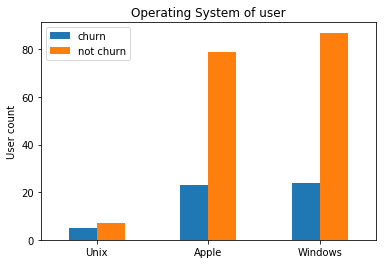

In [491]:
ax = df_OS.plot(kind='bar')
ax.set_xticklabels(['Unix','Apple', 'Windows'], rotation=0)
plt.ylabel('User count')
plt.title('Operating System of user');

In [492]:
df_gender = user_log_valid\
.dropDuplicates(['userId'])\
.groupby(['churned_user','gender'])\
.count()\
.toPandas()

In [493]:
df_gender = df_gender.sort_values(['gender', 'churned_user'], ascending = False)

In [494]:
df_gender

,churned_user,gender,count
2,1,M,32
1,0,M,89
0,1,F,20
3,0,F,84


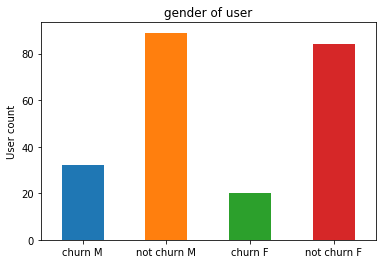

In [495]:
ax = df_gender['count'].plot(kind='bar')
ax.set_xticklabels(['churn M','not churn M','churn F','not churn F'], rotation=0)
plt.ylabel('User count')
plt.title('gender of user');

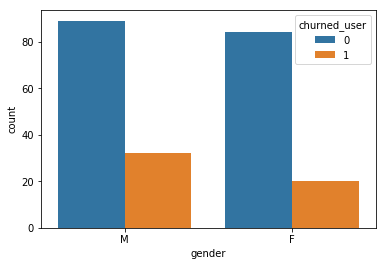

In [496]:
sns.barplot(x='gender',y='count',hue='churned_user',data=df_gender)

In [497]:
df_account = user_log_valid\
.dropDuplicates(['userId'])\
.groupby(['churned_user','level'])\
.count()\
.toPandas()

In [498]:
df_account = df_account.sort_values(['level', 'churned_user'], ascending = False)
df_account

,churned_user,level,count
2,1,paid,8
1,0,paid,40
3,1,free,44
0,0,free,133


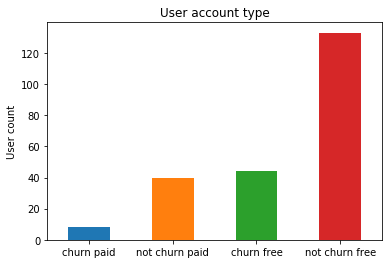

In [499]:
ax = df_account['count'].plot(kind='bar')
ax.set_xticklabels(['churn paid','not churn paid','churn free','not churn free'], rotation=0)
plt.ylabel('User count')
plt.title('User account type');

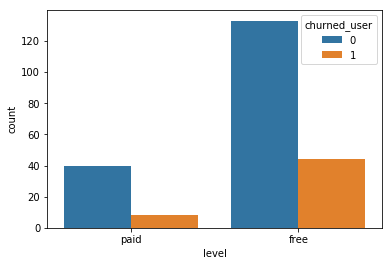

In [500]:
sns.barplot(x='level',y='count',hue='churned_user',data=df_account)

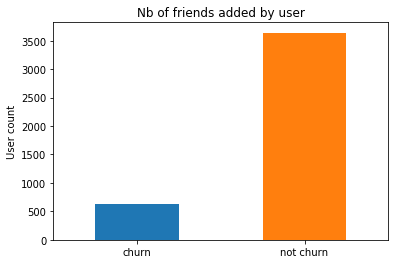

In [501]:
df_friends = user_log_valid\
.filter(user_log_valid.page == 'Add Friend')\
.groupby(['churned_user'])\
.count()\
.toPandas()

ax = df_friends['count'].plot(kind='bar')
ax.set_xticklabels(['churn','not churn'], rotation=0)
plt.ylabel('User count')
plt.title('Nb of friends added by user');

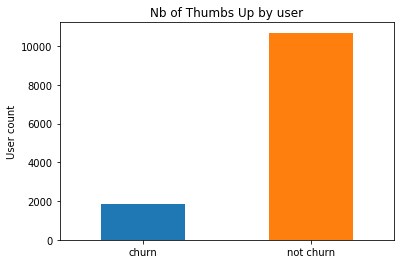

In [502]:
df_thumbsUp = user_log_valid\
.filter(user_log_valid.page == 'Thumbs Up')\
.groupby(['churned_user'])\
.count()\
.toPandas()

ax = df_thumbsUp['count'].plot(kind='bar')
ax.set_xticklabels(['churn','not churn'], rotation=0)
plt.ylabel('User count')
plt.title('Nb of Thumbs Up by user');

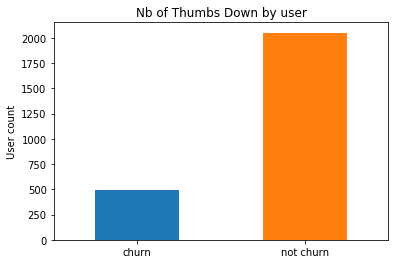

In [503]:
df_thumbsDown = user_log_valid\
.filter(user_log_valid.page == 'Thumbs Down')\
.groupby(['churned_user'])\
.count()\
.toPandas()

ax = df_thumbsDown['count'].plot(kind='bar')
ax.set_xticklabels(['churn','not churn'], rotation=0)
plt.ylabel('User count')
plt.title('Nb of Thumbs Down by user');

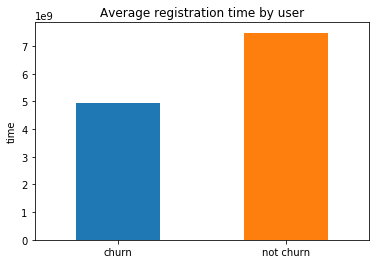

In [504]:
df_registrationTime = user_log_valid\
.select('userId','registration','ts','churned_user')\
.withColumn('lifetime',(user_log_valid.ts - user_log_valid.registration))\
.groupBy('churned_user','userId')\
.agg({'lifetime':'max'})\
.withColumnRenamed('max(lifetime)','lifetime') \
.select('userId', 'churned_user',  'lifetime') \
.groupby('churned_user')\
.agg({'lifetime':'avg'})\
.toPandas()

ax = df_registrationTime['avg(lifetime)'].plot(kind='bar')
ax.set_xticklabels(['churn','not churn'], rotation=0)
plt.ylabel('time')
plt.title('Average registration time by user');

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Let's build a spark dataframe based on the small dataset with userid being the key, and features the columns.
- max item in session
- total songs played
- total time spent listening songs
- total number of session
- OS family
- gender
- thumbs up
- thumbs down
- number of songs added to playlist
- number of friends added
- registration time


In [505]:
dfs_maxItemInSession = user_log_valid \
.select('userId','sessionId', 'itemInSession')\
.groupby('sessionId','userId')\
.agg({'itemInSession':'max'})\
.withColumnRenamed('max(itemInSession)','maxItemInSession') \
.select('userId','maxItemInSession')\
.groupby('userId')\
.agg({'maxItemInSession':'max'})\
.withColumnRenamed('max(maxItemInSession)','maxItemInSession')


In [506]:
dfs_maxItemInSession.filter(dfs_maxItemInSession.userId == '18').show(3)

+------+----------------+
|userId|maxItemInSession|
+------+----------------+
|    18|             184|
+------+----------------+



In [507]:
dfs_totalSongsPlayed = user_log_valid\
.where(user_log_valid["page"] == "NextSong")\
.groupby("userId")\
.agg({"page" : "count"})\
.withColumnRenamed("count(page)", "totalSongsPlayed")

In [508]:
dfs_totalSongsPlayed.show(3)

+------+----------------+
|userId|totalSongsPlayed|
+------+----------------+
|100010|             275|
|200002|             387|
|   125|               8|
+------+----------------+
only showing top 3 rows



In [509]:
dfs_totalTimePlayed = user_log_valid\
.where(user_log_valid["page"] == "NextSong")\
.groupby("userId")\
.agg({"length" : "sum"})\
.withColumnRenamed("sum(length)", "totalTimePlayed")

In [510]:
dfs_totalTimePlayed.show(3)

+------+------------------+
|userId|   totalTimePlayed|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
+------+------------------+
only showing top 3 rows



In [511]:
dfs_totalNumberSessions = user_log_valid\
.groupby("userId")\
.agg(F.countDistinct("sessionId"))\
.withColumnRenamed("count(DISTINCT sessionId)", "totalNbSessions")

In [512]:
dfs_totalNumberSessions.show(3)

+------+---------------+
|userId|totalNbSessions|
+------+---------------+
|100010|              7|
|200002|              6|
|   125|              1|
+------+---------------+
only showing top 3 rows



In [513]:
dfs_OSFamily = user_log_valid\
.select('userId','OS_family')\
.dropDuplicates()

In [514]:
dfs_OSFamily.show(3)

+------+---------+
|userId|OS_family|
+------+---------+
|    71|    Apple|
|   116|    Apple|
|200008|  Windows|
+------+---------+
only showing top 3 rows



In [515]:
OS_families = dfs_OSFamily.select("OS_family").distinct().rdd.flatMap(lambda x: x).collect()

In [516]:
OS_family = [F.when(F.col("OS_family") == OS, 1).otherwise(0).alias(OS) for OS in OS_families]

In [517]:
dfs_OSFamily = dfs_OSFamily.select('userID',*OS_family)

In [518]:
dfs_OSFamily.show(3)

+------+---------+-----+-------+
|userID|Unix-Like|Apple|Windows|
+------+---------+-----+-------+
|    71|        0|    1|      0|
|   116|        0|    1|      0|
|200008|        0|    0|      1|
+------+---------+-----+-------+
only showing top 3 rows



In [519]:
dfs_gender = user_log_valid\
.select('userId', 'gender')\
.dropDuplicates()\
.replace({'M':'1', 'F':'0'}, subset='gender')

In [520]:
dfs_gender.show(3)

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
+------+------+
only showing top 3 rows



In [521]:
dfs_thumbsUp = user_log_valid\
.select('userId','page')\
.where(user_log_valid['page'] == 'Thumbs Up')\
.groupby('userId')\
.agg(F.count('page'))\
.withColumnRenamed("count(page)", "nbThumbsUp")

In [522]:
dfs_thumbsUp.show(3)

+------+----------+
|userId|nbThumbsUp|
+------+----------+
|100010|        17|
|200002|        21|
|    51|       100|
+------+----------+
only showing top 3 rows



In [523]:
dfs_thumbsDown = user_log_valid\
.select('userId','page')\
.where(user_log_valid['page'] == 'Thumbs Down')\
.groupby('userId')\
.agg(F.count('page'))\
.withColumnRenamed("count(page)", "nbThumbsDown")

In [524]:
dfs_thumbsDown.show(3)

+------+------------+
|userId|nbThumbsDown|
+------+------------+
|100010|           5|
|200002|           6|
|    51|          21|
+------+------------+
only showing top 3 rows



In [525]:
dfs_addToPlaylist = user_log_valid\
.select('userId','page')\
.where(user_log_valid['page'] == 'Add to Playlist')\
.groupby('userId')\
.agg(F.count('page'))\
.withColumnRenamed("count(page)", "nbAddPlaylist")

In [526]:
dfs_addToPlaylist.show(3)

+------+-------------+
|userId|nbAddPlaylist|
+------+-------------+
|100010|            7|
|200002|            8|
|    51|           52|
+------+-------------+
only showing top 3 rows



In [527]:
dfs_addFriends = user_log_valid\
.select('userId','page')\
.where(user_log_valid['page'] == 'Add Friend')\
.groupby('userId')\
.agg(F.count('page'))\
.withColumnRenamed("count(page)", "nbAddFriend")

In [528]:
dfs_addFriends.show(3)

+------+-----------+
|userId|nbAddFriend|
+------+-----------+
|100010|          4|
|200002|          4|
|    51|         28|
+------+-----------+
only showing top 3 rows



In [529]:
dfs_registrationTime = user_log_valid\
.select('userId','registration','ts')\
.withColumn('lifetime',(user_log_valid.ts - user_log_valid.registration)/1000)\
.groupBy('userId')\
.agg({'lifetime':'max'})\
.withColumnRenamed('max(lifetime)','lifetime') \
.select('userId', 'lifetime')

In [530]:
dfs_registrationTime.show(3)

+------+---------+
|userId| lifetime|
+------+---------+
|100010|4807612.0|
|200002|6054448.0|
|   125|6161779.0|
+------+---------+
only showing top 3 rows



In [531]:
dfs_churned = user_log_valid\
.select('userId','churned_user')\
.dropDuplicates()

In [532]:
dfs_churned.show(3)

+------+------------+
|userId|churned_user|
+------+------------+
|100010|           0|
|200002|           0|
|   125|           1|
+------+------------+
only showing top 3 rows



In [533]:
dfs = dfs_maxItemInSession\
.join(dfs_totalSongsPlayed,on='userId')\
.join(dfs_totalTimePlayed,on='userId')\
.join(dfs_totalNumberSessions,on='userId')\
.join(dfs_OSFamily,on='userId')\
.join(dfs_gender,on='userId')\
.join(dfs_thumbsUp,on='userId')\
.join(dfs_addToPlaylist,on='userId')\
.join(dfs_addFriends,on='userId')\
.join(dfs_registrationTime,on='userId')\
.join(dfs_churned,on='userId')

In [534]:
dfs.show(3)

+------+----------------+----------------+------------------+---------------+---------+-----+-------+------+----------+-------------+-----------+-----------+------------+
|userId|maxItemInSession|totalSongsPlayed|   totalTimePlayed|totalNbSessions|Unix-Like|Apple|Windows|gender|nbThumbsUp|nbAddPlaylist|nbAddFriend|   lifetime|churned_user|
+------+----------------+----------------+------------------+---------------+---------+-----+-------+------+----------+-------------+-----------+-----------+------------+
|100010|             111|             275| 66940.89735000003|              7|        0|    1|      0|     0|        17|            7|          4|  4807612.0|           0|
|200002|             157|             387| 94008.87593999993|              6|        0|    1|      0|     1|        21|            8|          4|  6054448.0|           0|
|   124|             530|            4079|1012312.0927899999|             29|        0|    1|      0|     0|       171|          118|         74|

In [535]:
# As it is really long to come back at this point I decide to save this spark dataframe in a csv file
dfs.write.mode('overwrite').csv('dfs.csv',sep=';',header=True)


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [536]:
spark.sparkContext.version

'2.4.3'

The modeling will be done in several steps.
- VectorAssembler transformer to combine all features into a single vector which can be use with linear regression and decision tree ML models
- Normalizer to make sure our features are standardized before passed to any ML model or StandardScaler to have standard deviation and 0 mean
- a classifier: DecisionTreeClassifier, RandomForestClassifier, GBTClassifier (https://spark.apache.org/docs/2.4.3/ml-classification-regression.html)



In [537]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [538]:
# Now that we have saved the spark dataframe in a csv file, we can start again from here by loading this csv file
# looking at the doc, infershema looks nice ;=)
dfs = spark.read.csv('dfs.csv', sep=';', header=True, inferSchema=True)

In [539]:
dfs.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- maxItemInSession: integer (nullable = true)
 |-- totalSongsPlayed: integer (nullable = true)
 |-- totalTimePlayed: double (nullable = true)
 |-- totalNbSessions: integer (nullable = true)
 |-- Unix-Like: integer (nullable = true)
 |-- Apple: integer (nullable = true)
 |-- Windows: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- nbThumbsUp: integer (nullable = true)
 |-- nbAddPlaylist: integer (nullable = true)
 |-- nbAddFriend: integer (nullable = true)
 |-- lifetime: double (nullable = true)
 |-- churned_user: integer (nullable = true)



In [540]:
inColumns = [col for col in dfs.columns if col not in ['userId','churned_user']]

In [541]:
inColumns

['maxItemInSession',
 'totalSongsPlayed',
 'totalTimePlayed',
 'totalNbSessions',
 'Unix-Like',
 'Apple',
 'Windows',
 'gender',
 'nbThumbsUp',
 'nbAddPlaylist',
 'nbAddFriend',
 'lifetime']

In [542]:
# Train-test split
train, test = dfs.randomSplit([0.6, 0.4], seed=42)
#test, val = temp.randomSplit([0.5, 0.5], seed=42)

In [543]:
assembler = VectorAssembler(inputCols=inColumns , outputCol='vectorAssemblerFeatures')
scaler = StandardScaler(inputCol='vectorAssemblerFeatures', outputCol='standardScalerFeatures')

### Random Forest Classifier

In [544]:
randomForestClassifier = RandomForestClassifier(featuresCol='standardScalerFeatures', labelCol='churned_user')
pipeline = Pipeline(stages=[assembler, scaler, randomForestClassifier])

In [545]:
model = pipeline.fit(train)
preds = model.transform(test)

In [546]:
preds.select('userId','churned_user','prediction').show(3)

+------+------------+----------+
|userId|churned_user|prediction|
+------+------------+----------+
|     6|           0|       0.0|
|     7|           0|       0.0|
|    13|           0|       0.0|
+------+------------+----------+
only showing top 3 rows



In [547]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="churned_user", 
    predictionCol="prediction", 
    metricName="f1")

In [548]:
f1 = evaluator.evaluate(preds)
print('f1_score = {}'.format(f1))

p = preds['prediction','churned_user'].toPandas()
accuracy = np.sum(p['prediction'] == p['churned_user'])/len(p)
print('accuracy = {}'.format(accuracy))

f1_score = 0.6777435130673146
accuracy = 0.7195121951219512


### Decision Tree Classifier

In [549]:
decisionTreeClassifier = DecisionTreeClassifier(featuresCol='standardScalerFeatures', labelCol='churned_user')
pipeline = Pipeline(stages=[assembler, scaler, decisionTreeClassifier])
model = pipeline.fit(train)
preds = model.transform(test)

In [550]:
f1 = evaluator.evaluate(preds)
print('f1_score = {}'.format(f1))

p = preds['prediction','churned_user'].toPandas()
accuracy = np.sum(p['prediction'] == p['churned_user'])/len(p)
print('accuracy = {}'.format(accuracy))

f1_score = 0.6535937120168543
accuracy = 0.6707317073170732


### Gradient Boosted Tree Classifier

In [551]:
GBTClassifier = GBTClassifier(featuresCol='standardScalerFeatures', labelCol='churned_user')
pipeline = Pipeline(stages=[assembler, scaler, GBTClassifier])
model = pipeline.fit(train)
preds = model.transform(test)

In [552]:
f1 = evaluator.evaluate(preds)
print('f1_score = {}'.format(f1))

p = preds['prediction','churned_user'].toPandas()
accuracy = np.sum(p['prediction'] == p['churned_user'])/len(p)
print('accuracy = {}'.format(accuracy))

f1_score = 0.6535937120168543
accuracy = 0.6707317073170732


### Random Forest optimization with crossvalidator

In [553]:
pipeline = Pipeline(stages=[assembler, scaler, randomForestClassifier])

In [554]:
# https://spark.apache.org/docs/2.4.3/mllib-ensembles.html#random-forests
# https://spark.apache.org/docs/2.4.3/api/python/pyspark.ml.html#module-pyspark.ml.tuning
param_grid = ParamGridBuilder()\
.addGrid(randomForestClassifier.impurity, ['gini','entropy'])\
.addGrid(randomForestClassifier.numTrees, [40, 50, 60])\
.addGrid(randomForestClassifier.maxDepth, [10, 15])\
.build()

cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps = param_grid, 
                    evaluator = evaluator,
                    numFolds=2)

In [555]:
model = cv.fit(train)
preds = model.transform(test)

In [556]:
evaluator.evaluate(preds)

0.7245479917485742

In [557]:
model.bestModel.stages[2].extractParamMap()

{Param(parent='RandomForestClassifier_a38a87543ebd', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_a38a87543ebd', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_a38a87543ebd', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_a38a87543ebd', name='featuresCol', doc='features column name'): 'standardScalerFeatures',
 Param(parent='RandomForestClassifier_a

In [558]:
model.bestModel.stages[2].featureImportances

SparseVector(12, {0: 0.1321, 1: 0.1062, 2: 0.0751, 3: 0.0719, 4: 0.0041, 5: 0.0204, 6: 0.0135, 7: 0.016, 8: 0.1148, 9: 0.0944, 10: 0.0971, 11: 0.2544})

In [559]:
np.arange(len(inColumns))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

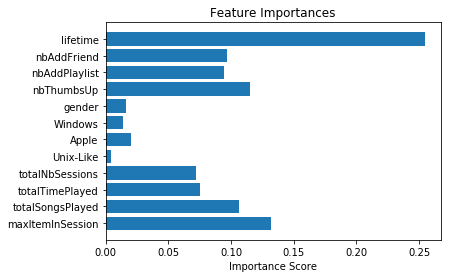

In [560]:
import matplotlib.pyplot as plt
feat_imp = model.bestModel.stages[2].featureImportances.values
y_pos = np.arange(len(inColumns))
 
plt.barh(y_pos, feat_imp, align='center')
plt.yticks(y_pos, inColumns)
plt.xlabel('Importance Score')
plt.title('Feature Importances');

# Conclusion
We have loaded and cleaned the data.
We have looked at some of the information available to us and made our choice on the one We decided to keep as relevant features.
Finally, we have build some model to predict on who will churn. This has been done with the help of a vector of feature, a scaler and a classifier. All of them have been added to a pipeline has we have learned during this Udacity training.
This has been quite some efforts to make this project, but a very instructive one, epecially learning the Spark syntax and understand its capabilities.
Thank you.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.